In [1]:
from math import log, sqrt, pi, exp
from scipy.stats import norm

from datetime import datetime, date

import numpy as np
import pandas as pd
from pandas import DataFrame

import pandas_datareader.data as web

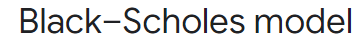

The Black Scholes model is considered to be one of the best ways of determining fair prices of options. It requires five variables: the strike price of an option, the current stock price, the time to expiration, the risk-free rate, and the volatility.

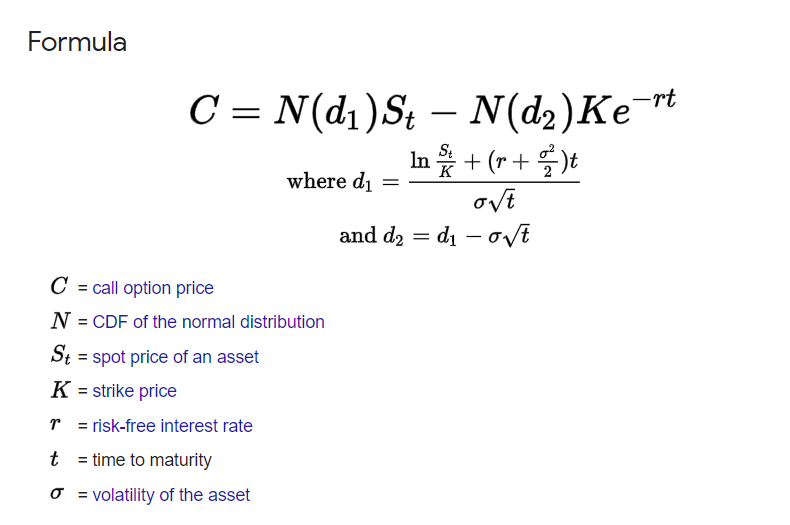

### In our model

C = call option price <br>
N = CDF of the normal distribution  <br>
St = spot price of an asset  <br>
K = strike price  <br>
r = risk-free interest rate  <br>
t = time to maturity  <br>
sigma(σ) = volatility of the asset  <br>

In [2]:
def d1(St, K, t, r, sigma):
    return(log(St/K) + (r + sigma**2/2.)*t)/(sigma*sqrt(t))

def d2(St, K, t, r, sigma):
    return d1(St, K, t, r, sigma) - sigma*sqrt(t)

In [3]:
def black_scholes_call(St, K, t, r, sigma):
    call_premium = St*norm.cdf(d1(St, K, t, r, sigma)) - K*exp(-r*t)*norm.cdf(d2(St, K, t, r, sigma))
    return call_premium
  
def black_scholes_put(St, K, t, r, sigma):
    put_premium = K*exp(-r*t)- St + black_scholes_call(St, K, t, r, sigma)
    return put_premium

In [4]:
stock = 'SPY'
expiry = '12-16-2022'
strike_price = 470

today = datetime.now()
yesterday = today.replace(day=today.day-1)
one_year_ago = today.replace(year=today.year-1)

df = web.DataReader(stock, 'yahoo', one_year_ago, today)

df = df.sort_values(by="Date")
df = df.dropna()
df = df.assign(close_day_before=df.Close.shift(1))
df['returns'] = ((df.Close - df.close_day_before)/df.close_day_before)

sigma = np.sqrt(252) * df['returns'].std()

risk_free_rate = (web.DataReader("^TNX", 'yahoo',yesterday, today)['Close'].iloc[-1]) / 100
spot_price = df['Close'].iloc[-1]
time = (datetime.strptime(expiry, "%m-%d-%Y") - datetime.utcnow()).days / 365

print('The Call Option Premium is: ', black_scholes_call(spot_price, strike_price, time, risk_free_rate, sigma))
print('The Put Option Premium is: ', black_scholes_put(spot_price, strike_price, time, risk_free_rate, sigma))

The Call Option Premium is:  26.40751702470334
The Put Option Premium is:  20.87534073010164


## Implied Volatility

It is defined as the expected future volatility of the stock over the life of the option. It is directly influenced by the supply and demand of the underlying option and the market’s expectation of the stock price’s direction. It could be calculated by solving the Black Scholes equation backwards for the volatility starting with the option trading price.

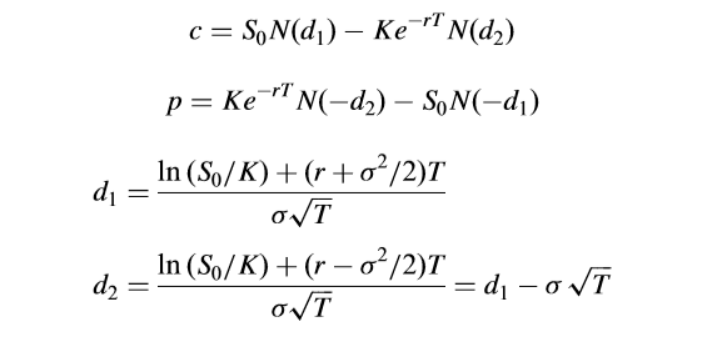

In [5]:
def call_implied_volatility(Price, St, K, t, r):
    sigma = 0.001
    while sigma < 1:
        Price_implied = St * \
            norm.cdf(d1(St, K, t, r, sigma))-K*exp(-r*t) * \
            norm.cdf(d2(St, K, t, r, sigma))
        if Price-(Price_implied) < 0.001:
            return sigma
        sigma += 0.001
    return "Not Found"

def put_implied_volatility(Price, St, K, t, r):
    sigma = 0.001
    while sigma < 1:
        Price_implied = K*exp(-r*t) - St + black_scholes_call(St, K, t, r, sigma)
        if Price-(Price_implied) < 0.001:
            return sigma
        sigma += 0.001
    return "Not Found"

print("Implied Volatility for call option: " +
      str(100 * round(call_implied_volatility(black_scholes_call(spot_price, strike_price, time, 
                    risk_free_rate, sigma,), spot_price, strike_price, time, risk_free_rate,),2)) + " %")

print("Implied Volatility for put option: " +
      str(100 * round(put_implied_volatility(black_scholes_call(spot_price, strike_price, time, 
                    risk_free_rate, sigma,), spot_price, strike_price, time, risk_free_rate,),2)) + " %")

Implied Volatility for call option: 13.0 %
Implied Volatility for put option: 16.0 %


## Option Greeks

Delta: the sensitivity of an option’s price changes relative to the changes in the underlying asset’s price. <br>
Gamma: the delta’s change relative to the changes in the price of the underlying asset.<br>
Vega: the sensitivity of an option price relative to the volatility of the underlying asset.<br>
Theta: the sensitivity of the option price relative to the option’s time to maturity.<br>
Rho: the sensitivity of the option price relative to interest rates.<br>

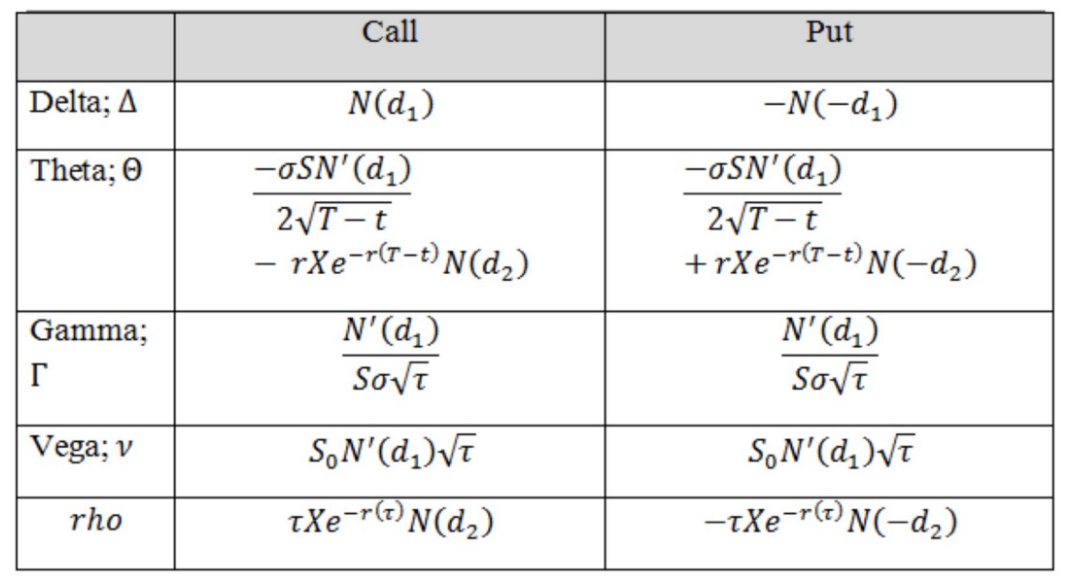

In [6]:
def gamma(St, K, t, r, sigma):
    return norm.pdf(d1(St, K, t, r, sigma))/(St*sigma*sqrt(t))

def vega(St, K, t, r, sigma):
    return 0.01*(St*norm.pdf(d1(St, K, t, r, sigma))*sqrt(t))

In [7]:
def call_delta(St, K, t, r, sigma):
    return norm.cdf(d1(St, K, t, r, sigma))

def call_theta(St, K, t, r, sigma):
    return 0.01*(-(St*norm.pdf(d1(St, K, t, r, sigma))*sigma)/(2*sqrt(t)) - r*K*exp(-r*t)*norm.cdf(d2(St, K, v, r, sigma)))

def call_rho(St, K, t, r, sigma):
    return 0.01*(K*t*exp(-r*t)*norm.cdf(d2(St, K, t, r, sigma)))

In [8]:
def put_delta(St, K, t, r, sigma):
    return -norm.cdf(-d1(St, K, t, r, sigma))

def put_theta(St, K, t, r, sigma):
    return 0.01*(-(St*norm.pdf(d1(St, K, t, r, sigma))*sigma)/(2*sqrt(t)) + r*K*exp(-r*t)*norm.cdf(-d2(St, K, t, r, sigma)))

def put_rho(St, K, t, r, sigma):
    return 0.01*(-K*t*exp(-r*t)*norm.cdf(-d2(St, K, t, r, sigma)))